<a href="https://colab.research.google.com/github/Hassan-Mahadjir/Machine-Learning/blob/main/CNN_Cats%26Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from zipfile import ZipFile

from sklearn.model_selection import train_test_split
# !pip install torchmetrics
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
)

In [ ]:
# Get data - convert images to dataFrame
os.environ['KAGGLE_USERNAME'] = "your-kaggle-username"
os.environ['KAGGLE_KEY'] = "your-kaggle-key"

!kaggle competitions download -c dogs-vs-cats


 99% 801M/812M [00:11<00:00, 173MB/s]
100% 812M/812M [00:11<00:00, 75.5MB/s]


In [ ]:
# unzip fils
def safe_unzip(path):
    if os.path.exists(path):
        try:
            with ZipFile(path, 'r') as z:
                z.extractall()
        except Exception as e:
            print(f"Skip unzip {path}: {e}")

safe_unzip('dogs-vs-cats.zip')
safe_unzip('train.zip')
safe_unzip('test1.zip')

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
# Create a DataFrame with a subset of the training data

# Get the list of training images
train_dir = './train'
test_dir = './test1'

assert os.path.isdir(train_dir), f"Missing {train_dir}"
assert os.path.isdir(test_dir),  f"Missing {test_dir}"

# Sample a portion of the training data (e.g., 10% of the images)
train_files = [f for f in os.listdir(train_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
assert len(train_files) > 0, "train/ directory has no images"

sample_ratio = 1.0  # 10%
sample_size  = max(1, int(len(train_files) * sample_ratio))
sampled_files = np.random.choice(train_files, sample_size, replace=False)

df = pd.DataFrame({'filename': sampled_files})
# label: dog=0, cat=1 (matches your convention)
df['label'] = df['filename'].apply(lambda x: 0 if 'dog' in x.lower() else 1)

# split into train/val
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=SEED)

print(f"Train size: {len(train_df)} | Val size: {len(val_df)}")
print("Train label distribution:\n", train_df['label'].value_counts())
print("Val   label distribution:\n", val_df['label'].value_counts())

Train size: 20000 | Val size: 5000
Train label distribution:
 label
1    10000
0    10000
Name: count, dtype: int64
Val   label distribution:
 label
1    2500
0    2500
Name: count, dtype: int64


In [ ]:
class CatsDogsDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, labelled=True):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.labelled = labelled

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fname = self.df.iloc[idx]['filename']
        path = os.path.join(self.img_dir, fname)
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.labelled:
            label = int(self.df.iloc[idx]['label'])
            return img, label
        else:
            # return dummy label for consistent collate
            return img, -1

In [ ]:
# Convert MNIST Files into Tensor of 4-D (# of images, Hight, Width, Colour channel)
transform = transforms.Compose([
    transforms.Resize((112, 112)),   # to match CNN fc1 input
    transforms.ToTensor()
])

batch_size = 32
# Training and Evaluation datasets
train_dataset = CatsDogsDataset(train_df, train_dir, transform, labelled=True)
val_dataset   = CatsDogsDataset(val_df,   train_dir, transform, labelled=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Unlabeled test set
test_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
test_df = pd.DataFrame({'filename': test_files})
test_dataset = CatsDogsDataset(test_df, test_dir, transform, labelled=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class ConvolutionalNN(nn.Module):
  def __init__(self,in_channels,num_classes):
    """
    Convolutional Neural Network for image classification
    Args:
      in_channels (int): Number of input channels (e.g., 3 for RGB images)
      num_classes (int): Number of output classes (e.g., 2 for 2-class classification) 0 = dog, 1 = cat
    """
    super(ConvolutionalNN,self).__init__()
    # 1st CNN layer
    self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=(3,3),stride=(1,1),padding=(1,1))
    # Max pooling layer
    self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
    # 2nd CNN layer
    self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),stride=(1,1),padding=(1,1))
    # Fully connected layer
    self.fc1 = nn.Linear(in_features=16*28*28,out_features=num_classes) # 112x112 → pool → 56x56 → pool → 28x28

  def forward(self,x):
    """
    Forward pass of the convolutional neural network
    Args:
      x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width)
    Returns:
      torch.Tensor: Output tensor of shape (batch_size, num_classes)
    """
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0],-1) #x = x.view(x.size(0), -1)
    x = self.fc1(x)
    return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvolutionalNN(in_channels=3,num_classes=2).to(device)
model

ConvolutionalNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12544, out_features=2, bias=True)
)

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
best_val_acc = 0.0
best_epoch = 0
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # evaluate on validation set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.4f} Val Acc: {val_acc:.4f}")

    # save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch+1
        torch.save(model.state_dict(), "best_model.pth")

print(f"✅ Best Epoch: {best_epoch} with Val Acc = {best_val_acc:.4f}")



Epoch [1/20] Loss: 0.3308 Val Acc: 0.7634
Epoch [2/20] Loss: 0.3149 Val Acc: 0.7560
Epoch [3/20] Loss: 0.3037 Val Acc: 0.7558
Epoch [4/20] Loss: 0.2936 Val Acc: 0.7524
Epoch [5/20] Loss: 0.2846 Val Acc: 0.7554
Epoch [6/20] Loss: 0.2717 Val Acc: 0.7494
Epoch [7/20] Loss: 0.2585 Val Acc: 0.7494
Epoch [8/20] Loss: 0.2502 Val Acc: 0.7362
Epoch [9/20] Loss: 0.2394 Val Acc: 0.7456
Epoch [10/20] Loss: 0.2281 Val Acc: 0.7466
Epoch [11/20] Loss: 0.2210 Val Acc: 0.7496
Epoch [12/20] Loss: 0.2109 Val Acc: 0.7358
Epoch [13/20] Loss: 0.2061 Val Acc: 0.7412
Epoch [14/20] Loss: 0.1977 Val Acc: 0.7382
Epoch [15/20] Loss: 0.1887 Val Acc: 0.7384
Epoch [16/20] Loss: 0.1787 Val Acc: 0.7300
Epoch [17/20] Loss: 0.1775 Val Acc: 0.7264
Epoch [18/20] Loss: 0.1663 Val Acc: 0.7388
Epoch [19/20] Loss: 0.1552 Val Acc: 0.7328
Epoch [20/20] Loss: 0.1596 Val Acc: 0.7332
✅ Best Epoch: 1 with Val Acc = 0.7634


In [ ]:
# ====== Evaluate on Validation with TorchMetrics (multiclass with 2 classes) ======
acc       = MulticlassAccuracy(num_classes=2).to(device)
precision = MulticlassPrecision(num_classes=2, average='macro').to(device)
recall    = MulticlassRecall(num_classes=2,   average='macro').to(device)
f1        = MulticlassF1Score(num_classes=2, average='macro').to(device)

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device, dtype=torch.long)
        logits = model(images)
        preds  = torch.argmax(logits, dim=1)

        acc.update(preds, labels)
        precision.update(preds, labels)
        recall.update(preds, labels)
        f1.update(preds, labels)

val_acc = acc.compute().item()
val_pre = precision.compute().item()
val_rec = recall.compute().item()
val_f1  = f1.compute().item()

print(f"\nValidation — Acc: {val_acc:.4f} | Prec: {val_pre:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")


Validation — Acc: 0.7598 | Prec: 0.7605 | Rec: 0.7598 | F1: 0.7596


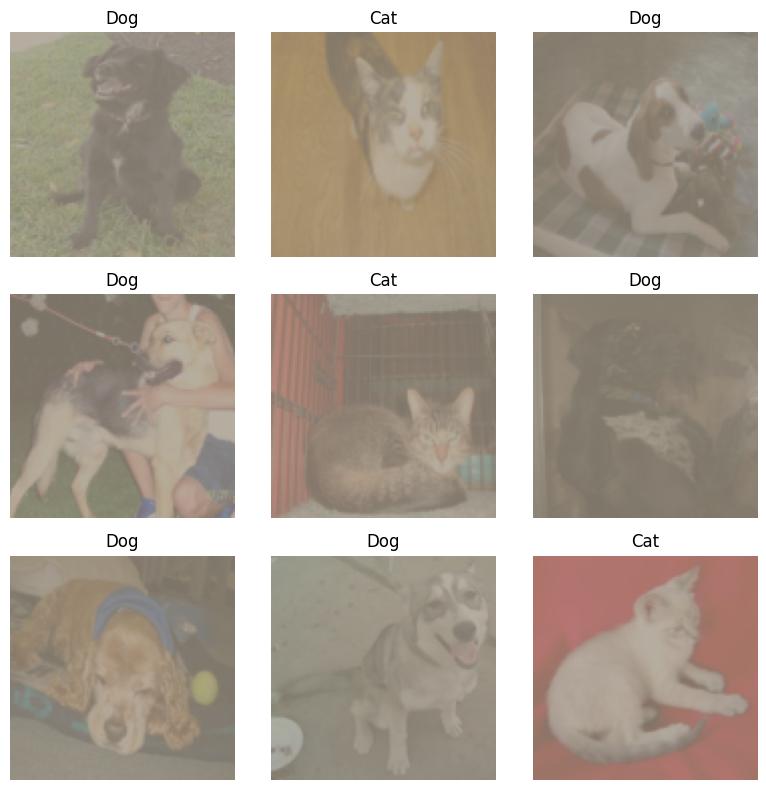

In [ ]:
# Visualize a few train images
batch_imgs, batch_labels = next(iter(train_loader))
plt.figure(figsize=(8,8))
for i in range(min(9, batch_imgs.size(0))):
    plt.subplot(3,3,i+1)
    # undo normalization just for display
    img = batch_imgs[i].cpu().permute(1,2,0).numpy()
    img = (img * [0.229,0.224,0.225]) + [0.485,0.456,0.406]
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title("Dog" if int(batch_labels[i])==0 else "Cat")
    plt.axis('off')
plt.tight_layout()
plt.show()

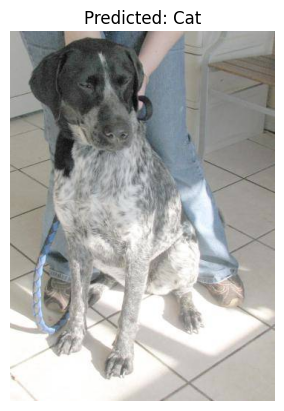

In [ ]:
# Test model
model.eval()
rand_test = random.choice(test_df['filename'].tolist())
img_path = os.path.join(test_dir, rand_test)
img = Image.open(img_path).convert('RGB')

with torch.no_grad():
    tens = transform(img).unsqueeze(0).to(device)
    logits = model(tens)
    pred = torch.argmax(logits, dim=1).item()

plt.imshow(img)
plt.title(f"Predicted: {'Dog' if pred==0 else 'Cat'}")
plt.axis('off')
plt.show()


In [ ]:
preds = []
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        logits = model(images)
        batch_preds = torch.argmax(logits, dim=1).cpu().tolist()
        preds.extend(batch_preds)

submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': preds  # 0=Dog, 1=Cat
})
submission.to_csv('submission.csv', index=False)
print("\nSaved predictions to submission.csv")
print(submission.head())


Saved predictions to submission.csv
    filename  label
0   2595.jpg      0
1   7648.jpg      0
2   4992.jpg      1
3  11205.jpg      1
4   9747.jpg      0
